# Anthropic paper explainer notebook

We discuss this [paper](https://transformer-circuits.pub/2021/framework/index.html#d-footnote-15) in this notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from einops import rearrange, reduce, repeat
import matplotlib.pyplot as plt
from tqdm import tqdm

We'll be using the same hyperparams

In [2]:
d = 32  # embedding dimension
v = 128  # vocabulary size
l = 64  # sequence length
h = 4  # no. of heads
# dh = d // h  # head dimension

## Standard interpretation of attention

We have a matrix $t \in \mathbb{R}^{l \times v}$ of $l$ one-hot vectors where $l$ is the sequence length. We have an embedding matrix $W_E \in \mathbb{R}^{v \times d}$ where $d$ is the embedding dimension. $tW_E$ gets us the embedding vectors $x$ to input into the model, and $x = tW_E \in \mathbb{R}^{l \times d}$

In [3]:
# nn.Embedding : torch.long -> torch.float
# accepts a tensor of token ids and maps each to an embedding
We = nn.Embedding(v, d)

# example
tokens = torch.randint(0, v, (l,))  # shape (l,)
x = We(tokens)  # shape (l, d) = (64, 32)
x.shape

torch.Size([64, 32])

Next we have the query, key, value, and atention output projection matrices $W_q, W_k, W_v, W_o \in \mathbb{R}^{d \times d}$. We also choose the number of heads $h$ and $h \vert d$. We get $q, k,$ and $v$ by doing the projections

$\{q, k, v\} = xW_{\{q, k, v\}}$

In [4]:
Wq, Wk, Wv, Wo = [torch.randn(d, d) for _ in range(4)]

q, k, v = x @ Wq, x @ Wk, x @ Wv  # (l, d) @ (d, d) = (l, d)

q.shape, k.shape, v.shape

(torch.Size([64, 32]), torch.Size([64, 32]), torch.Size([64, 32]))

and then we split $Q, K,$ and $V$ along the embedding dimension (i.e., the second dimension) for multi-head attention

In [5]:
qs, ks, vs = map(
  lambda m: rearrange(m, 'l (h dh) -> h l dh', h=h),
  (q, k, v)
)

qs.shape, ks.shape, vs.shape

/Users/karthik/Desktop/environments/chat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(torch.Size([4, 64, 8]), torch.Size([4, 64, 8]), torch.Size([4, 64, 8]))

Visually, we did this

<img src="head_split.png" height=384, width=608>

Now we transpose all the key matrices like so

<img src="key_transpose.png" height=144 width=1120>


In [6]:
ks = rearrange(ks, 'h l dh -> h dh l')
ks.shape

torch.Size([4, 8, 64])

Now we do a simple mat mul b/w all the query matrices and key matrices and take softmax along the last dimension to get the attention score matrices

<img src="attention_.png" height=960 width=784>

We must add a causal mask to our query key dot product matrix before softmax-ing it. We create a lower triangular matrix of 1s, subtract one to turn the 1s to 0s and the zeros above the diagonal to -1, then we replace the -1s with -inf

In [7]:
m = torch.tril(torch.ones(l, l)) - 1
m[m == -1] = float('-inf')
print(m.shape)
print(m)

torch.Size([64, 64])
tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])


We now compute attention scores

In [8]:
scores = F.softmax(qs @ ks + m, -1)  # (h, l, dh) @ (h, dh, l) = (h, l, l)
scores.shape

torch.Size([4, 64, 64])

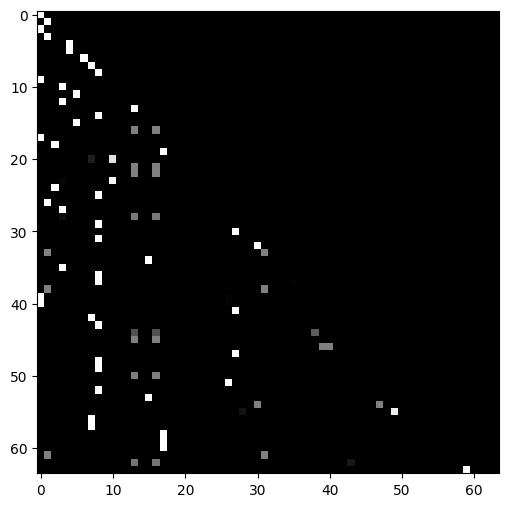

In [9]:
# there are h score matrices – shape (h, l, l) – one for each head
# we visualize the first 

fig = plt.figure(figsize=(6, 6))
plt.imshow(scores[0].detach().numpy(), cmap='gray')
plt.show()

Now we mat mul each attention score matrix $S_i = Q_iK_i$ in `scores` with the corresponding value matrix $V_i$ in `vs` and get the heads

<img src="score_vs.png" height=960 width=768>

In [10]:
heads = scores @ vs  # (h, l, l) @ (h, l, dh) = (h, l, dh)

heads.shape

torch.Size([4, 64, 8])

We then concatenate the heads (first image) then do a mat mul with $W_o$ (second image) to get the final output

<img src="attn_orig.png" height=640 width=512>

In [11]:
# (h, l, dh) -> (l, d)
# (l, d) @ (d, d) = (l, d)
attention_original = rearrange(heads, 'h l dh -> l (h dh)') @ Wo

x.shape == attention_original.shape == (l, d)

True

In [12]:
attention_original

tensor([[-26.7898, -40.5536, -31.7684,  ...,  44.2484,  23.8010, -20.8165],
        [ 20.4618,  55.5261,  -4.4693,  ...,  -7.6764, -43.5488, -84.5420],
        [-40.5892, -57.2393, -41.2147,  ...,  11.1041,  24.3113,  49.8133],
        ...,
        [ 27.3018, -14.0709,  21.4640,  ..., -24.1097, -91.7262,  -7.5286],
        [-19.8293, -17.5503,  10.3039,  ..., -55.9022, -64.8398,  34.3185],
        [ 45.9931,  -5.1464,  18.5283,  ..., -44.9761, -15.5306,   8.1222]],
       grad_fn=<MmBackward0>)

## Reinterpretation

We leave the embedding projection as is. We split $W_{\{q, k, v\}} \in \mathbb{R}^{d \times d}$ along the column $h$ times to get $h$ matrices $W_{\{q, k, v\}}^1, \ldots, W_{\{q, k, v\}}^h\in \mathbb{R}^{d \times \lfloor\frac{d}{h}\rfloor}$ and split $W_o$ along the row $h$ times to get $W_o^1, \ldots, W_o^h \in \mathbb{R}^{\lfloor \frac{d}{h} \rfloor \times d}$

$W_{\{q, k, v\}}$ split like so

<img src="wqkv_split.png" height=180 width=468>

$W_o$ is split like so

<img src="wo_split.png" height=180 width=720>

In [13]:
# splitting Wq, Wk, Wv along the column h times
Wq, Wk, Wv = map(
  lambda m: rearrange(m, 'd (h dh) -> h d dh', h=h),
  (Wq, Wk, Wv)
)  # (d, d) -> (h, d, dh)

Wq.shape, Wk.shape, Wv.shape

(torch.Size([4, 32, 8]), torch.Size([4, 32, 8]), torch.Size([4, 32, 8]))

In [14]:
# splitting Wo along the row h times
Wo = rearrange(Wo, '(h dh) d -> h dh d', h=h)  # (d, d) -> (h, dh, d)

Wo.shape

torch.Size([4, 8, 32])

We won't be computing `vs` here, because we want to show the QK and OV circuit distinction

In [15]:
qs, ks = x @ Wq, x @ Wk  # (l, d) @ (h, d, dh) = (h, l, dh)

qs.shape, ks.shape 

(torch.Size([4, 64, 8]), torch.Size([4, 64, 8]))

We have

$H^i = \text{softmax}(Q^i {K^i}^T) V^i W_o^i$

where $H^i \in \mathbb{R}^{l \times d}$. We know $V_i$ is $xW_v^i$ so we seperate $H_i$ as a product of two terms

$H^i = \text{softmax}(Q^i {K^i}^T)(xW_v^i)W_o^i = (\text{softmax}(Q^i {K^i}^T)x)(W_v^i W_o^i)$

where the left term in the product is the QK circuit (determines source token value that information gets transferred FROM) and the right term is the OV circuit (determines subspace of source token value and subspace of destination token value and transfers info from one to the other). Now, attention is just the sum of all $H_i$

$A = \sum_{i = 1}^h H_i$

We are of course not computing the one by one, we are doing batched mat mul and a reduction here

In [16]:
ks = rearrange(ks, 'h l dh -> h dh l')  # transpose last 2 dims of ks first

# QK circuit
qk = F.softmax(qs @ ks + m, -1) @ x # (h, l, dh) @ (h, dh, l) @ (l, d) = (h, l, d)
print(qk.shape)

# OV circuit
ov = Wv @ Wo  # (h, d, dh) @ (h, dh, d) = (h, d, d)
print(ov.shape)

# compute H_i for all i
Hs = qk @ ov  # (h, l, d) @ (h, d, d) = (h, l, d)
print(Hs.shape)

torch.Size([4, 64, 32])
torch.Size([4, 32, 32])
torch.Size([4, 64, 32])


We now do the reduction

In [17]:
attention_new = reduce(Hs, 'h l d -> l d', 'sum')  # (h, l, d) -> (l, d)

x.shape == attention_new.shape == (l, d)

True

Let's check if `attention_new` is equal to `attention_original`. We should expect `attention_new == attention_original` to return false in some positions because of the non-associative nature of doing mat mul in a computer, but if we manually inspect the values, they should look the same

In [18]:
attention_new == attention_original

tensor([[False, False, False,  ..., False,  True, False],
        [False,  True, False,  ..., False,  True, False],
        [False, False, False,  ..., False,  True, False],
        ...,
        [ True, False, False,  ...,  True, False, False],
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ...,  True, False, False]])

In [19]:
attention_new

tensor([[-26.7898, -40.5536, -31.7684,  ...,  44.2484,  23.8010, -20.8165],
        [ 20.4618,  55.5261,  -4.4693,  ...,  -7.6764, -43.5488, -84.5420],
        [-40.5892, -57.2393, -41.2147,  ...,  11.1041,  24.3113,  49.8133],
        ...,
        [ 27.3018, -14.0709,  21.4640,  ..., -24.1097, -91.7263,  -7.5286],
        [-19.8293, -17.5503,  10.3039,  ..., -55.9022, -64.8398,  34.3185],
        [ 45.9931,  -5.1464,  18.5283,  ..., -44.9761, -15.5306,   8.1222]],
       grad_fn=<SumBackward1>)

In [20]:
attention_original

tensor([[-26.7898, -40.5536, -31.7684,  ...,  44.2484,  23.8010, -20.8165],
        [ 20.4618,  55.5261,  -4.4693,  ...,  -7.6764, -43.5488, -84.5420],
        [-40.5892, -57.2393, -41.2147,  ...,  11.1041,  24.3113,  49.8133],
        ...,
        [ 27.3018, -14.0709,  21.4640,  ..., -24.1097, -91.7262,  -7.5286],
        [-19.8293, -17.5503,  10.3039,  ..., -55.9022, -64.8398,  34.3185],
        [ 45.9931,  -5.1464,  18.5283,  ..., -44.9761, -15.5306,   8.1222]],
       grad_fn=<MmBackward0>)